In [1]:
!pip install sentence-transformers
!pip install tf-keras
!pip install tensorflow
!pip install sentence-transformers
!pip install seaborn
!pip install nltk

In [2]:
import os
import re
import string
import pickle
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

warnings.simplefilter(action="ignore", category=FutureWarning)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

nltk.download("wordnet")

2025-11-07 13:59:33.236625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762523973.259197   56912 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762523973.266666   56912 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762523973.286234   56912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762523973.286256   56912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762523973.286259   56912 computation_placer.cc:177] computation placer alr

True

In [3]:
hr_data=pd.read_csv('data_with_internal_info.csv', low_memory=False)
def text_prep(text):
    text = [str(t).lower() for t in text]
    table = str.maketrans('', '', string.punctuation)
    text = [t.translate(table) for t in text]
    text = [t.replace('\n', ' ') for t in text]
    text = [re.sub(r'[^a-zA-Z0-9._\s]', '', t) for t in text]
    text = [re.sub(r'\s+', ' ', t).strip() for t in text]
    return text
os.environ["LD_LIBRARY_PATH"] = os.path.join(os.environ["CONDA_PREFIX"], "lib") + ":" + os.environ.get("LD_LIBRARY_PATH", "")
hr_data['Yearly Gross Base Salary'] = pd.to_numeric(hr_data['Yearly Gross Base Salary'], errors='coerce')
hr_data = hr_data.dropna(subset=['Yearly Gross Base Salary'])
columns_to_combine = [
    'Job Title (en)', 'Job Title (nl)', 'Level Title', 'Function goal', 
    'Key result areas: result area (1)', 'Key result areas: result area (2)',
    'Key result areas: result area (3)', 'Key result areas: result area (4)',
    'Key result areas: result area (5)', 'Key result areas: result area (6)',
    'Key result areas: result area (7)', 'Key result areas: result area (8)',
    'Key result areas: result area (9)', 'Key result areas: result area (10)',
    'Key result areas: result area (11)', 'Specify the budget amounts.', 
    'Diploma Category', 'Speciality', 'Required experience', 'Innovation', 
    'Row 4 - Column 1', 'Row 5 - Column 1',
    'Row 6 - Column 1', 'Row 7 - Column 1', 'Row 8 - Column 1','Internal Job', 'Internal Job Grade', 'Department']

hr_data[columns_to_combine] = hr_data[columns_to_combine].astype(str)
text_combined = hr_data[columns_to_combine].agg(' '.join, axis=1).tolist()
text_cleaned = text_prep(text_combined)

model_Sen = SentenceTransformer('all-mpnet-base-v2')
text_cleaned = text_prep(text_combined)

embeddings = model_Sen.encode(text_cleaned, convert_to_numpy=True, show_progress_bar=True, batch_size=100)

X = pd.DataFrame(embeddings)

y = hr_data[['Yearly Gross Base Salary', 'Compas Grade']].copy()
y_imputed = y.fillna(y.mean())

scaler_y = StandardScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y_imputed), columns=y_imputed.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=11)


model = Sequential([
    Input(shape=(X_train.shape[1],)),  #i have 1 input with 384 feature (minilm) and 2 output
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2)  
])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(35).repeat()
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(35)

model.fit(train_dataset, epochs=40, steps_per_epoch=len(X_train) // 35,
          validation_data=validation_dataset, validation_steps=len(X_test) // 35)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)


# Separate evaluation for each target
print("--- Separate Target Evaluation ---")
for i, col in enumerate(y.columns):
    print(f"{col}:")
    print("  MAE:", mean_absolute_error(y_true[:, i], y_pred[:, i]))
    print("  RMSE:", mean_squared_error(y_true[:, i], y_pred[:, i]) ** 0.5)
    print("  R2:", r2_score(y_true[:, i], y_pred[:, i]))
    print("  MAPE:", mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]))

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2025-11-07 14:16:14.833772: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-07 14:16:14.833816: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-11-07 14:16:14.833825: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-11-07 14:16:14.833829: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-07 14:16:14.833835: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: samaneh-workbench
2025-11-07 14:16:14.833840: I external/local_xla/xla/stream_executor/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,002 (2.38 MB)

 Trainable params: 624,002 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3846 - mae: 0.4527 - mse: 0.3846 - val_loss: 0.2870 - val_mae: 0.3721 - val_mse: 0.2870
Epoch 2/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2959 - mae: 0.3926 - mse: 0.2959 - val_loss: 0.2731 - val_mae: 0.3590 - val_mse: 0.2731
Epoch 3/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2763 - mae: 0.3763 - mse: 0.2763 - val_loss: 0.2681 - val_mae: 0.3557 - val_mse: 0.2681
Epoch 4/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2698 - mae: 0.3699 - mse: 0.2698 - val_loss: 0.2698 - val_mae: 0.3574 - val_mse: 0.2698
Epoch 5/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2633 - mae: 0.3629 - mse: 0.2633 - val_loss: 0.2569 - val_mae: 0.3443 - val_mse: 0.2569
Epoch 6/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2586 - mae: 0.3604 - mse: 0.2586 - val_loss: 0.2696 - val_mae: 0.3478 - val_mse: 0.2696
Epoch 7/40
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2556 - mae: 0.3579 - mse: 0.2556 - val

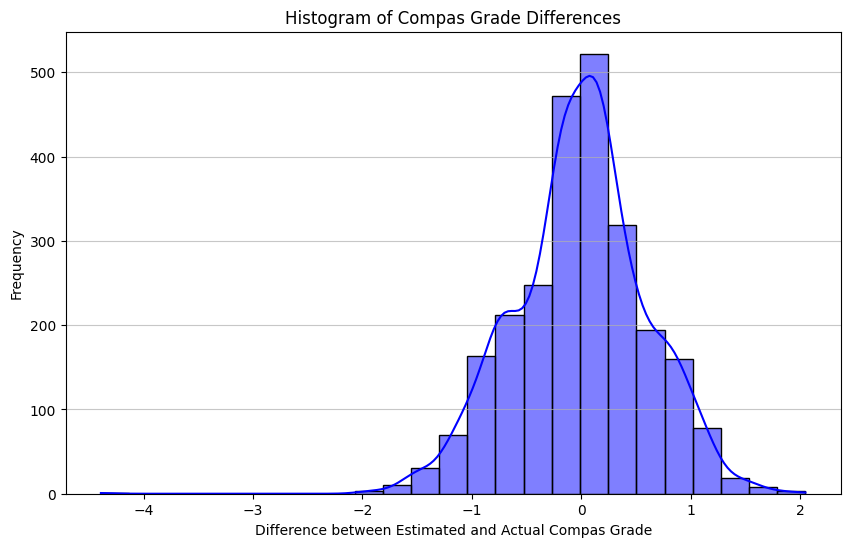

In [4]:
errors = y_pred - y_true
errors_df = pd.DataFrame(errors, columns=y.columns)

plt.figure(figsize=(10,6))
sns.histplot(errors_df["Compas Grade"], kde=True, bins=25, color='blue')

plt.title('Histogram of Compas Grade Differences')
plt.xlabel('Difference between Estimated and Actual Compas Grade')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.7)
plt.show()

In [6]:
sample_job_description=""" 
Working at Randstad is unlike working at any organization. Because at Randstad we put people at the heart of everything we do. This goes for our clients, our talent, our employees and society. We combine our passion for people with the power of today’s technologies. This helps us support people and organizations in realizing their true potential. Learn more about our mission, history and values on our website: www.randstad.com
how you will contribute :

As a Machine Learning Engineer / Data Scientist you will create brand new insights into the global world of work. We use the latest ML and AI techniques to deliver highly accurate models for supporting a variety of business applications and processes, including market demand, talent supply, career patterns, salaries and rates, and pricing.

The focus in this role will be working on our global taxonomy program, that is supporting our systems landscape worldwide. In this program we are creating and maintaining information on all kinds of vital elementary data concepts, such as jobs, occupations, skills, certificates, education and more. We are using the latest ML technology and LLMs to create our models, and present the results via ML pipelines with a balanced set of microservices.

You will be a part of an international and agile team of highly skilled specialists, including data scientists, ML engineers, data engineers, and data analysts. We have a major research background and are publishing some of our greatest work in academic papers.

You will work closely with other colleagues within the Randstad ecosystem, especially in the various global projects. The impact of your work depends not only on the quality of your products, but especially on your ability to communicate the value and proof of concept of your models and analyses.

what you will be doing 

building Machine Learning (ML) models: preparing data from a wide variety of internal and external data sources; creating and evaluating ML models, primarily in the NLP domain, based a.o. on open source LLMs and GenAI; 

● building ML pipelines that automate the training and deployment of models

● defining and appropriating work to the product backlog

● training and coaching junior team members

● collaborating within the data science community within the Randstad ecosystem, on sharing best practices, harmonizing ML models, and grow collective data science skills
who will you work with 

Our global data science team helps our customers make better hiring decisions and helps talent advance in their career paths. We help people find work by creating new insights into the dynamics of the global labor market and integrate those insights into customer- and talent-focused data products. We build and deploy machine learning models and tell stories with those insights. As an example - we create clarity where there are gaps in diversity, what a talent's next job might be, how market conditions should influence a hiring strategy, where we predict demand will go, and much more.

what you will bring 

● Masters degree in Computer science / Data Science, or related technical studies (M.Sc. or equivalent experience)
● min. 2 to 3 years work experience as a ML engineer or data scientist with strong engineering skills
● machine learning (ML) platform: excellent working knowledge of analytical, AI and ML stacks on cloud platforms, preferably on Google Cloud Platform (incl. BigQuery, AI & ML stack) or comparable platforms
● coding: high proficiency in Python (incl. relevant libraries and packages) and SQL
● ML engineering: experience with the creation of ML pipelines and ML Ops related techniques
● ML modeling: relevant experience with NLP, LLMs, and working with the set of tools needed to build models on large and complex datasets (preferably in applied and research setting)

what’s in it for you 

We put people at the heart of everything we do. Our employment conditions reflect this;

● competitive salary
● an additional flexible benefit budget
● attractive bonus scheme
● option to take part in Randstad's success through our employee Share Purchase Plan
● option to go on a sabbatical leave or buy extra holidays
● flexible working hours in the office or hybrid]
● attractive mobility arrangements
● opportunity to give back to local communities through paid volunteering leave
● a generous budget to set up your home office space and a net internet allowance]

● growth and development opportunities in a fast changing global environment

● working with great people and being part of a network where everyone wants you to succeed

● an environment where differences are understood, valued and celebrated

We want our teams and talent to reflect the rich diversity of the societies we serve. We thrive for an environment of belonging, safety and confidence. So everyone can bring their whole selves to work and flourish. Learn more about equity, diversity, inclusion and belonging at randstad here.

If you recognize yourself in the profile above, we invite you to apply for this role.

For more information you can reach out to our recruitment business partner Jenny Roberts .

The recruitment procedure consists of a screening and at least two interviews. Later in the process, an (online) assessment and a job offer conversation take place

"""

In [7]:
your_text = text_prep([sample_job_description])
your_text_embeddings = model_Sen.encode(your_text, convert_to_numpy = True) 

estimatation = model.predict(your_text_embeddings)
estimation_original = scaler_y.inverse_transform(estimatation)

print("Estimated salary for the job ==> ", int(estimation_original[0][0]), "Euro")
print("Estimated compas grade:", round(estimation_original[0][1], 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Estimated salary for the job ==>  45467 Euro
Estimated compas grade: 11.86


In [8]:
# Ask for Hrs feedback
import os, csv, datetime as dt

salary_eur   = int(estimation_original[0, 0])
compas_grade = float(round(float(estimation_original[0, 1]), 2))

def ask_and_save(salary, grade, job_desc, out_path="outputs/prediction_feedback.csv"):
    while True:
        try:
            resp = input("Do you accept the result? [y/n]: ").strip().lower()
        except EOFError:
            print("No input available (non-interactive). Skipping save.")
            return
        if resp in ("y", "yes", "n", "no"):
            break
        print("Please answer with y/yes or n/no.")

    if resp.startswith("n"):
        # ensure folder exists
        folder = os.path.dirname(out_path)
        if folder:
            os.makedirs(folder, exist_ok=True)

        write_header = not os.path.exists(out_path)
        with open(out_path, "a", newline="", encoding="utf-8") as f:
            w = csv.DictWriter(f, fieldnames=["timestamp","salary_eur","compas_grade","job_description"])
            if write_header:
                w.writeheader()
            w.writerow({
                "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
                "salary_eur": salary,
                "compas_grade": grade,
                "job_description": job_desc
            })
        print(f" Saved to {out_path}")
    else:
        print(" Not saved.")

ask_and_save(salary_eur, compas_grade, sample_job_description)

Do you accept the result? [y/n]:  n


 Saved to outputs/prediction_feedback.csv
